# Load Library

In [1]:
import os
import numpy as np
import pandas as pd
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim.models import Word2Vec

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing

## Load Dataset

This project leverages a dataset of Indonesian news articles collected from [Tribunnews](https://www.tribunnews.com/) using web scraping techniques.

In [3]:
df = pd.read_csv('dataset/teks_berita.csv')
df.head(10)

,Title,Link,Content,Upload Time
0,BREAKING NEWS: Hotel Aruss Semarang Disita Pol...,https://muria.tribunnews.com/2025/01/06/breaki...,Content not found,1 jam lalu
1,"Jadwal Film Bioskop Pati Hari Ini, Senin 6 Jan...",https://muria.tribunnews.com/2025/01/06/jadwal...,Content not found,1 jam lalu
2,"Update Harga Emas Antam di Semarang Hari Ini, ...",https://muria.tribunnews.com/2025/01/06/update...,Content not found,1 jam lalu
3,"Jadwal Film Bioskop Blora Hari Ini, Senin 6 Ja...",https://muria.tribunnews.com/2025/01/06/jadwal...,Content not found,1 jam lalu
4,Nekat Terobos Perlintasan Kereta Api di Pemala...,https://muria.tribunnews.com/2025/01/05/nekat-...,Content not found,16 jam lalu
5,Profil Pengacara Alvin Lim yang Meninggal Duni...,https://muria.tribunnews.com/2025/01/05/profil...,Content not found,18 jam lalu
6,"Jadwal Film Bioskop Pati Hari Ini, Minggu 5 Ja...",https://muria.tribunnews.com/2025/01/05/jadwal...,Content not found,1 hari lalu
7,"Kronologi Kecelakaan Beruntun di Purwokerto, D...",https://muria.tribunnews.com/2025/01/05/kronol...,Content not found,1 hari lalu
8,"Niat Cari Ikan, Pemancing di Blora Temukan May...",https://muria.tribunnews.com/2025/01/05/niat-c...,Content not found,1 hari lalu
9,NaN,NaN,Error: Invalid URL 'nan': No scheme supplied. ...,NaN


Dari tampilan data di awal banyak sekali *missing value* pada column utama (`Content`) yang bertuliskan "Content not found" atau Error yang kemungkinan disebabkan oleh terjadinya error saat scrapping.

## Cleansing

### Drop Missing Value and Clean Text
Missing value di data tidak terdeteksi sebagai `NaN` sehingga tidak bisa dilakukan langsung menggunakan `df.dropna`.

In [4]:
df_content = df[['Title', 'Content']].copy()
df_content.tail(5)

,Title,Content
3015,Ribuan Wisatawan Padati Destinasi di Trawas Mo...,"SURYA.CO.ID, MOJOKERTO- Kunjungan wisatawan sa..."
3016,"Libur Tahun Baru 2025, Kawasan Wisata Makam Bu...","SURYA.CO.ID, KOTA BLITAR- Kawasan wisata sejar..."
3017,Daftar 23 Peserta Indonesian Idol 2025 yang Lo...,SURYA.CO.ID -Sebanyak 31 pesertaIndonesian Ido...
3018,2 Sosok yang Beri Uang Gepokan Rp 112 Juta ke ...,"SURYA.co.id- Donasi untukSunhaji,penjual es te..."
3019,Dicetak Pakai Mesin Canggih Seharga Rp 600 Jut...,SURYA.co.id- Kenali ciri-ciriuang palsuyang di...


In [5]:
def cleansing_text(text):
    text = text.lower()

    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\b[a-z0-9-]+\.(com|net|org|info|co\.id)\b', ' ', text)

    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    total_words = len(text.split())
    if total_words < 15:
        return np.nan
    
    return text

cleansing_text(df_content.loc[2500, 'Content'])

'berikut inicara beli tiket mrtpakai gopay per desember 2024 pastikan sudah punyaaplikasi mymrtj pt mrt jakarta perseroda kembali meluncurkan layanan beli tiket mrt pakai gopay mulai kamis 26 12 2024 hal itu diungkap oleh direktur pengembangan bisnis pt mrt jakarta perseroda farchad mahfud setelah melalui kerja sama dengan gopay tentunya dengan bergabungnya gopay akan semakin menambah pilihan baru terhadap fleksibilitas dan inklusivitas metode pembayaran tiket mrt kata dia gopay sempat dihapus dari metode pembayaran tiket mrt mulai juli 2024 saat itu pt mrt jakarta mengakhiri kontrak kerja sama antara mrt dengangopay ovo dana dan linkaja lantas bagaimana cara beli tiket mrt pakai gopay dikutip dari laman resmi mrt jakarta total ada 14 metode pembayaran tiket mrt yaitu gopay dana e money martipay tapcash brizzi dan flazz selain itu ada pula mastercard jaklingko astrapay blu i saku dan kredivo berikutcara beli tiket mrtmenggunakangopay head of gopay wallet kelvin timotius mengatakan pemb

Function `cleaning_text` membersihkan teks dengan cara:
* 1. Merubah semua huruf ke lowercase di kode `text.lower()`.
* 2. Menghapus link atau sumber untuk mengurangi text yang tidak memiliki pengaruh pada proses pengelompokkan.
* 3. Menghapus karakter aneh yang jarang digunakan dalam teks (non-ascii) termasuk emoji.
* 4. Menghapus tanda baca.
* 5. Menghapus spasi berlebih.
* 6. Mengosongkan value pada panjang text yang kurang dari 15.  Hal ini dilakukan untuk mengatasi missing value yang tidak terdeteksi sebagai NaN seperti "Content Not Found".

In [6]:
print(f"Total NaN Before Cleaning : {df_content['Content'].isna().sum()}")
df_content.loc[:, 'Content'] = df_content.loc[:, 'Content'].apply(cleansing_text)
print(f"Total NaN After Cleaning : {df_content['Content'].isna().sum()}")

Total NaN Before Cleaning : 0
Total NaN After Cleaning : 520


In [7]:
df_content.dropna(inplace=True)
df_content.reset_index(drop=True, inplace=True)
print(f"Total data bersih :{len(df_content)}")

Total data bersih :2500


Setelah proses cleaning, jumlah data menjadi 2500.

### Remove Stopwords

In [8]:
stopwords_id = set(stopwords.words('indonesian'))

def remove_stopwords(text: str):    
    tokens = text.split()
    filtered = [t for t in tokens if t not in stopwords_id]

    return " ".join(filtered)

example_text = df_content.loc[2025, 'Content']
print(f"ACTUAL TEXT \n {example_text} \n")
print(f"CLEAN TEXT \n {remove_stopwords(example_text)}")

ACTUAL TEXT 
 surabaya ada banyak cara menghabiskan waktu bersama anak dengan bermain roller skate park bertema retro di mall ciputra world surabaya area permainan sepatu roda ini hadir dengan warna yang kalem yakni pink dan biru dengan dua kategori bermain yang memfokuskan pada aktivitas anak pengunjung bisa memilih inline skate itu buat kecepatan dan quad skate atraksi ketika para pengunjung bermain sudah tersedia sepatu roda ungkap public relation promotion ciputra world surabayastephana fevriera minggu 5 1 2025 ia menjelaskan pada inlane skate sangat cocok bagi pengunjung yang ingin melakukan balap sepatu roda sementara yang menyukai atraksi dengan empat roda menyala bisa bermain di quad skate bagi pemula tak perlu khawatir jika ingin mencoba aktivitas bermain skate park untuk tiket bermain di roller skate park dibanderol rp 80 ribu di sini pengunjung bisa menyewa kostum retro tema 80 an riera sapaan akrabnya menyebut petugas dan alat bantu telah disiapkan untuk memberikan kesempat

In [9]:
df_content['Content'] = df_content['Content'].apply(remove_stopwords)

Kata stopwords perlu di hapus dalam teks processing ini karena stopwords tidak terlalu memiliki makna atau value dalam metode ekstraksi konvensional.

## Frequent Words Analysis

In [10]:
def get_frequent_word(data):
    text = " ".join(list(data.str.lower()))
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    df_word_freq = pd.DataFrame(data = {'word': list(word_count.keys()), 'freq': list(word_count.values())})

    df_word_freq.sort_values(by='freq', ascending=False, inplace=True)
    df_word_freq.reset_index(drop=True, inplace=True)

    return df_word_freq

df_word_freq = get_frequent_word(df_content['Content'])

In [11]:
print(df_word_freq.head(30)['word'].tolist())
print(df_word_freq.head(30)['freq'].tolist())

['1', '2025', '2024', 'baca', 'jalan', '12', 'korban', 'desa', '2', 'pemain', 'tol', 'kabupaten', '3', 'kecamatan', 'orang', 'jawa', 'jakarta', 'mobil', 'masyarakat', 'rumah', 'pelaku', 'warga', 'kota', '5', 'persen', 'tim', 'rp', 'anak', 'wib', 'daerah']
[3654, 3250, 3018, 2433, 1866, 1737, 1690, 1656, 1555, 1395, 1367, 1362, 1289, 1246, 1199, 1156, 1145, 1111, 1070, 1060, 1043, 1021, 981, 963, 933, 890, 876, 875, 869, 862]


Berdasarkan hasil top 30 kata yang sering muncul di data menunjukkan: 
* Cluster Kriminal & Kecelakaan dengan Kata kunci: korban, pelaku, mobil, jalan, tol. Berita kecelakaan lalu lintas dan tindak kriminal sepertinya porsi terbesar dataset ini.
* Cluster Berita Daerah & Desa dengan Kata kunci: desa, kecamatan, kabupaten, daerah, warga, masyarakat.
* Cluster Olahraga (Kemungkinan Bola) Kata kunci: pemain, tim. Kemungkinan besar ada segmen berita sepak bola yang cukup banyak.
* Cluster Ekonomi Kata kunci: rp (Rupiah), persen.

In [12]:
print(df_word_freq.tail(30)['word'].tolist())
print(df_word_freq.tail(30)['freq'].tolist())

['pendaran', 'penggalangan', 'squash', 'pandangannya', 'merupakanuang', 'palsudengan', 'diterawang', 'alauddinmakassardalam', 'lahallo', 'inkjet', 'managermeotel', 'temawisata', 'dafamini', 'eueng', 'printer', 'offset', 'kuak', 'watermark', 'electrotype', 'berpendar', 'limbek', 'aktivitasaipda', 'reservasi', 'hubungimeotel', 'damayanti', 'prahara', 'jovitta', 'sally', 'bended', 'knee']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Berdasarkan hasil top 30 kata yang jarang muncul di data menunjukkan 2 indikasi utama:
* 1. Banyak kata yang seharusnya lebih dari satu kata namun terdeteksi sebagai satu kata karena tidak memiliki pemisah (spasi). Menunjukkan adanya kesalahan dalam proses scrapping.
* 2. Kata tersebut memang jarang muncul di dataset berita ini atau adanya kesalahan penulisan.

Tidak dilakukan pembersihan pada kata-kata yang jarang muncul ini karena dikhawatirkan beberapa kata yang mengandung makna pada berita ikut hilang.

## EDA Preprocessing

### Wordcloud hasil preprocessing

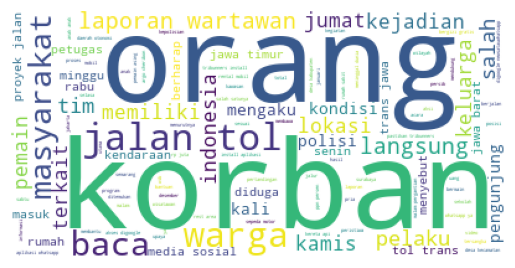

In [13]:
wc = WordCloud(background_color="white", max_words=200).generate(" ".join(df_content['Content'].tolist()))
plt.imshow(wc)
plt.axis('off')
plt.show()

Hasil dari wordcloud menunjukkan bahwa di dalam dataset ini sebagian besar berita membahas tentang kejahatan kriminal atau bencana berdasarkan kata kunci 'korban' dan 'orang'.

### Distribusi panjang berita

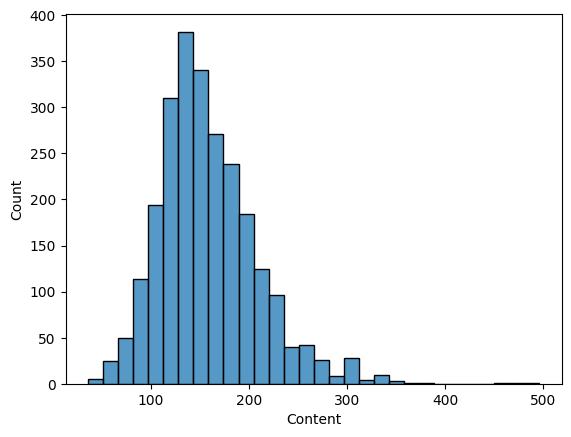

In [15]:
content_lengths = df_content['Content'].str.split().apply(len)
sns.histplot(content_lengths, bins=30)
plt.show()

Berdasarkan histogram distribusi panjang berita kebanyakan berita berisi 100 s.d. 200 total kata di dalamnya.

# Feature Engineering

## Feature Extraction

Kami membandingkan dua metode di proses ekstraksi fitur ini yaitu metode TF-IDF dan Word to Vector (Word2vec). Hasil dari perbandingan dua metode ini ditunjukkan oleh seberapa bagus hasil dari clustering-nya.

### TF-IDF Method

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    sublinear_tf=True
)

X_tfidf = tfidf_vectorizer.fit_transform(df_content['Content'])
X_tfidf.shape

(2500, 10000)

Parameter:
* `ngram_range= (1, 2)` : mengambil unigrams (1 kata) dan bigram (2 kata) sebagai fitur. Dengan menyertakan bigram, pemaknaan kata menjadi lebih luas.
* `max_features=10000` : jumlah fitur maximal sebesar 10000. Dibatasi 10000 untuk efisiensi memori agar hasil ekstraksi tidak terlalu besar.
* `sublinear_tf=True` : Teknik normalisasi logaritma. Berfungsi untuk menurunkan perbedaan value yang terlalu besar.

### Word2vec Method
Proses ekstraksi menggunakan model word2vec pretrained dari github [Dery Rahman](https://github.com/deryrahman/word2vec-bahasa-indonesia) yang sudah di latih pada data wikipedia berbahasa Indonesia.

In [17]:
model = Word2Vec.load('model/idwiki_word2vec_100/idwiki_word2vec_100.model')
model.wv.most_similar('korban', topn=5)

[('korbannya', 0.7245351076126099),
 ('tawanan', 0.6330045461654663),
 ('sandera', 0.6238601207733154),
 ('pengungsi', 0.6186887621879578),
 ('pelaku', 0.614471971988678)]

In [18]:
def get_vector(text, model):
    tokens = text.split()
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_word2vec = []
for i in range(df_content.shape[0]):
    vec = get_vector(df_content.loc[i, 'Content'], model)
    X_word2vec.append(vec)
X_word2vec = np.array(X_word2vec)
X_word2vec.shape

(2500, 100)

Metode digunakan:
* **Mean Vector** : Hasil representasi setiap vektor dirata-ratakan untuk meringkas makna dari berita.

# Clustering

Penentuan jumlah class yang cocok menggunakan elbow method.

## TF-IDF Features

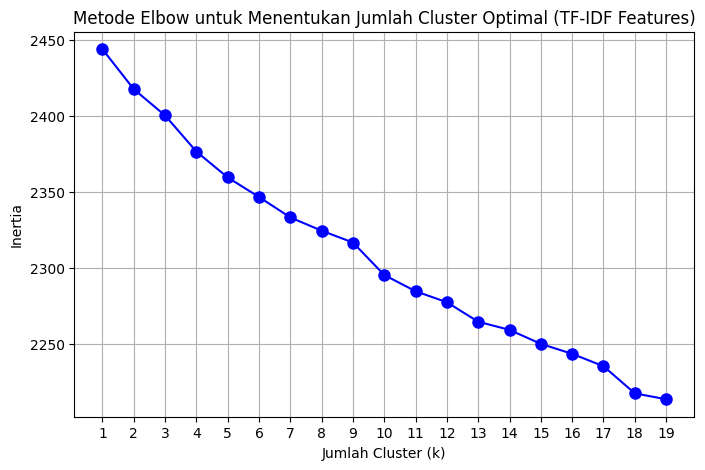

In [19]:
k_values = range(1, 20)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='random', random_state=0)
    kmeans.fit(X_tfidf)
    inertia = kmeans.inertia_
    inertia_values.append(inertia)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, 'bo-', markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal (TF-IDF Features)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Patahan terlihat jelas pada cluster 10. Jadi jumlah cluster yang cocok sebanyak 10 class.

In [25]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
kmeans.fit(X_tfidf)
df_content['cluster_TF-IDF'] = kmeans.labels_

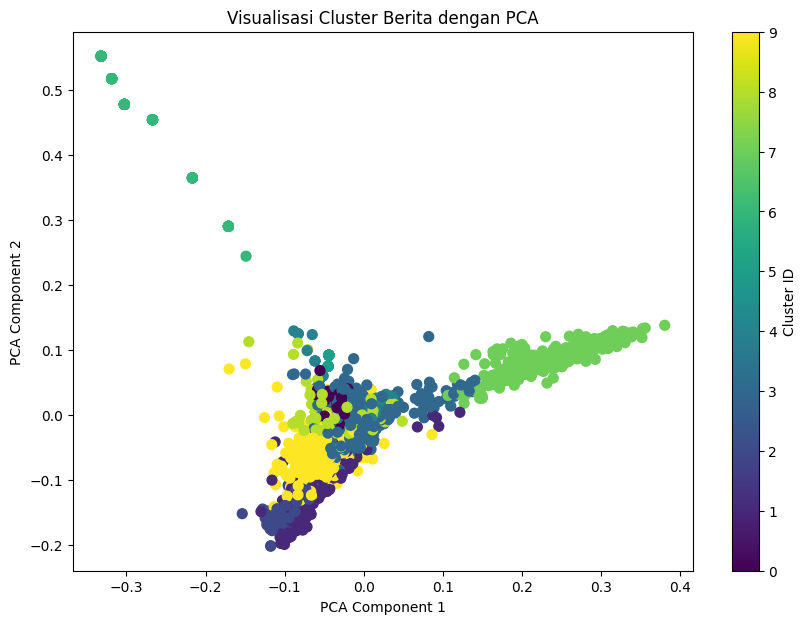

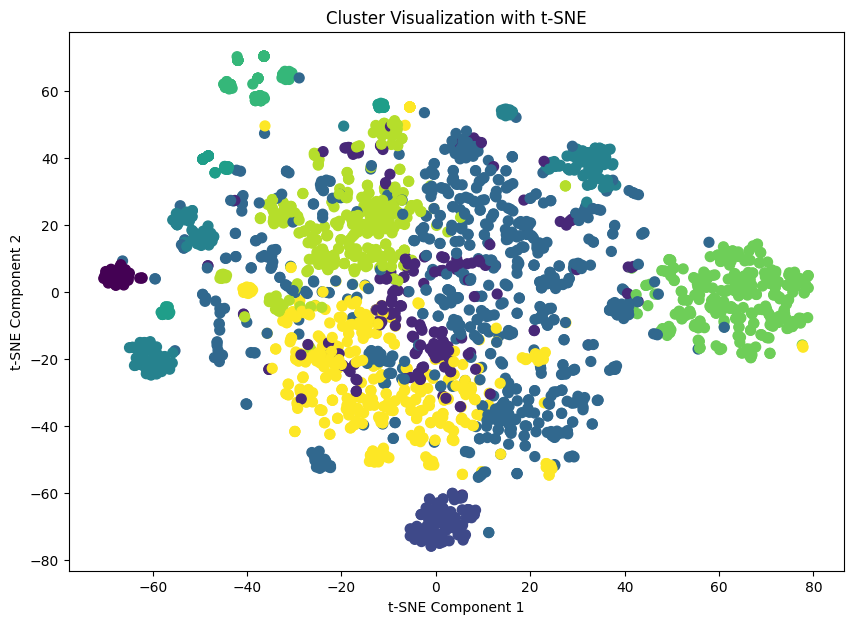

Silhouette Score: 0.0309


In [26]:
pca = PCA(n_components=2)
X_pca_tfidf = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(X_pca_tfidf[:, 0], X_pca_tfidf[:, 1], c=df_content['cluster_TF-IDF'], cmap='viridis', s=50)
plt.title('Visualisasi Cluster Berita dengan PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

tsne = TSNE(n_components=2, random_state=42)
X_tsne_tfidf = tsne.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_tfidf[:, 0], X_tsne_tfidf[:, 1], c=df_content['cluster_TF-IDF'], cmap='viridis', s=50)
plt.title("Cluster Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

silhouette_avg = silhouette_score(X_tfidf, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")

## Word2Vec Features

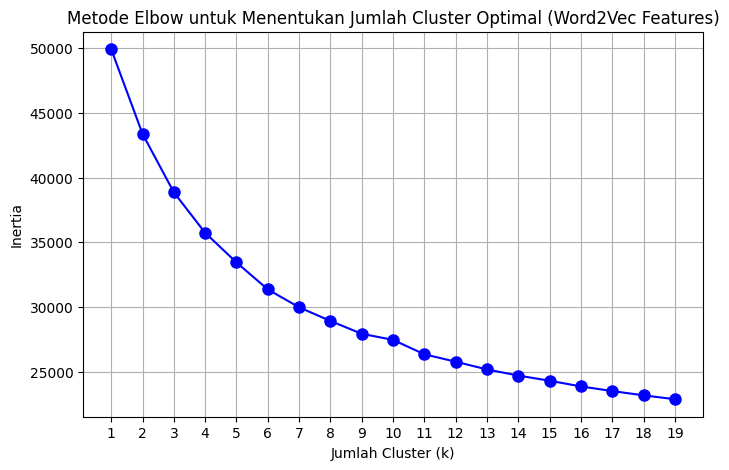

In [27]:
k_values = range(1, 20)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='random', random_state=0)
    kmeans.fit(X_word2vec)
    inertia = kmeans.inertia_
    inertia_values.append(inertia)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, 'bo-', markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal (Word2Vec Features)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Patahan terlihat jelas pada cluster 10. Jadi jumlah cluster yang cocok sebanyak 10 class.

In [28]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
kmeans.fit(X_word2vec)
df_content['cluster_word2vec'] = kmeans.labels_

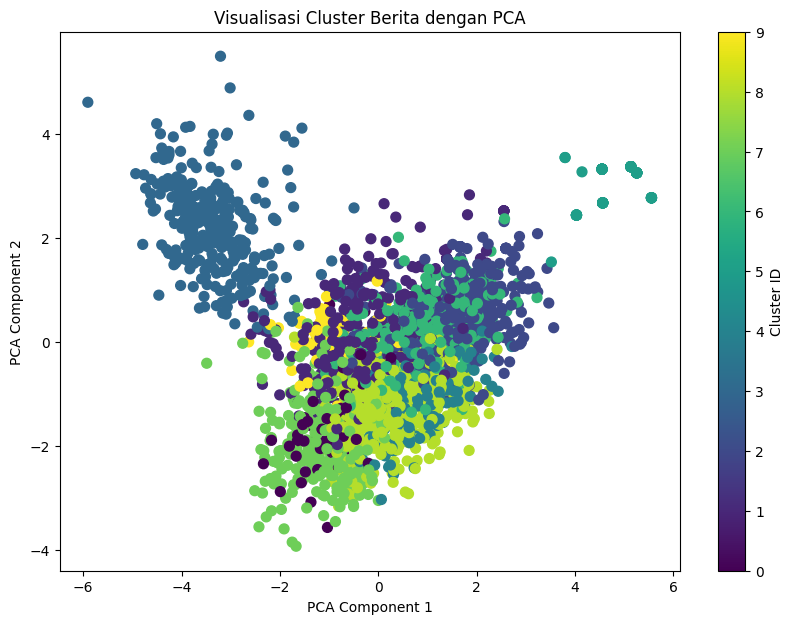

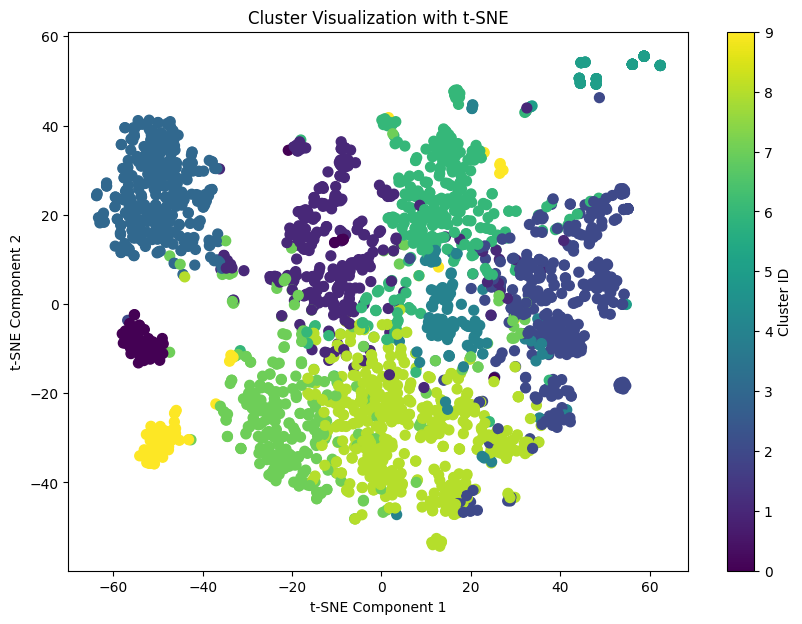

Silhouette Score: 0.1571


In [29]:
pca = PCA(n_components=2)
X_pca_word2vec = pca.fit_transform(X_word2vec)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca_word2vec[:, 0], X_pca_word2vec[:, 1], c=df_content['cluster_word2vec'], cmap='viridis', s=50)
plt.title('Visualisasi Cluster Berita dengan PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

tsne = TSNE(n_components=2, random_state=42)
X_tsne_word2vec = tsne.fit_transform(X_word2vec)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_word2vec[:, 0], X_tsne_word2vec[:, 1], c=df_content['cluster_word2vec'], cmap='viridis', s=50)
plt.title("Cluster Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Cluster ID')
plt.show()

silhouette_avg = silhouette_score(X_word2vec, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")

## Analisis Hasil Clustering

* 1. Berdasarkan visualisasi hasil clustering di atas hasil clustering termasuk cukup buruk dari kedua metode. Semua cluster berkumpul pada titik yang berdekatan dan tumpang tindih terutama pada visualisasi dengan pca, hal ini menunjukkan cluster tidak tersebar dengan baik.
* 2. Berdasarkan silhouette score, nilainya terbilang cukup kecil yang menunjukan perbedaan tiap class tidak memiliki perbedaan atau karakteristik yang bermakna. Nilai dari Word2vec lebih tinggi meskipun dari hasil visualisasi cluster word2vec terlihat sangat bercampur dan tumpang tindih.

## Implementasi Hasil

Hasil pelabelan dari clustering di implementasikan pada data dengan cara menampilkan 5 judul berita setiap class dan pengambilan dilakukan secara random.

### Hasil dari fitur **TF-IDF**

In [37]:
for c in range(n_clusters):
    hasil_cluster = df_content[df_content['cluster_TF-IDF'] == c].sample(5)['Title']
    print(f'========== Cluster = {c+1} ==========')
    print(hasil_cluster)
    print(f'==============================\n')

========== Cluster = 1 ==========
2395    Wabah PMK Mulai Masuk Kabupaten Madiun, Pedaga...
2203    Dipertahankan Ponorogo Sebut PMK Mulai Ada Sej...
2461    Cegah Wabah Penyakit Mulut dan Kuku di Kabupat...
2447    Dampak PMK Kembali Merebak di Mojokerto, Peter...
2390    Wabah PMK Merebak di Kabupaten Madiun, Pemkab ...
Name: Title, dtype: object

========== Cluster = 2 ==========
1835    Warga Jaktim Harap Pemerintah Serius Tangani B...
1743    Tahun Baru 2025, Penumpang Kereta Api Tinggalk...
1794    Puluhan Ribu Pengunjung Padati TMII, Pertunjuk...
1606    LPSK Sesalkan Putusan PN Surabaya Atas Restitu...
1892    Dikira Tenggelam di Ciliwung, Seorang Pemuda T...
Name: Title, dtype: object

========== Cluster = 3 ==========
91      Fakta Baru, Penyewa Kendaraan Pakai KTP Palsu,...
106     Polisi Militer Turun Tangan, Selidiki Dugaan K...
1114    Petuah Bos Rental Mobil Membekas, Anak Kandung...
1617    Tipu Daya Ajat Sudrajat Bikin Pemilik Rental Y...
1118    Penampakan Mobil Brio 

#### Analisis Per-Cluster

* Cluster 1 : Wabah Penyakit Hewan (PMK)\
    Pengelompokkan berita ini karena kata kunci "PMK", "Wabah", dan nama-nama daerah di Jawa Timur sangat dominan dan konsisten. Ini adalah contoh cluster yang sangat bagus.

* Cluster 2 : Berita Umum Kota & Sosial (General News)\
    Ini terlihat seperti cluster "penampungan" atau miscellaneous. Topiknya melompat dari banjir (Ciliwung), liburan (TMII), hingga hukum (LPSK/PN Surabaya). Kemungkinan dokumen-dokumen ini tidak memiliki fitur kata yang cukup kuat untuk masuk ke cluster spesifik lain.

* Cluster 3 : Kriminalitas (Kasus Rental & Penipuan)\
    Cluster ini sangat tajam. Fokus pada satu narasi kriminalitas yang besar (kemungkinan kasus pembunuhan bos rental yang sempat viral) dan penipuan kendaraan.

* Cluster 4 : Pemerintahan Daerah & Selebriti (Campuran)\
    Sama seperti Cluster 2, ini adalah cluster yang kurang koheren. Berita tentang program pemerintah (makan bergizi) bercampur dengan berita selebriti (Mahalini) dan tips teknologi (Hacker). Mungkin perlu stopword removal yang lebih agresif agar topik ini bisa terpisah.

* Cluster 5 : Religi & Gadget (Tips & Info)\
    Menarik karena algoritma menyatukan "Agama" dan "Gadget". Kemungkinan besar ini terjadi karena kesamaan struktur bahasa seperti "Tips", "Daftar Harga", "Manfaat", atau "Keutamaan". Secara semantik berbeda, tapi secara struktur teks mungkin dianggap mirip.

* Cluster 6 : Transportasi KA & Pemekaran Wilayah\
    Meskipun ada dua sub-topik (Kereta dan Pemekaran Wilayah), keduanya berkaitan dengan logistik dan administrasi wilayah (Jawa Barat). Masih cukup masuk akal.

* Cluster 7 : Infrastruktur (Pembangunan Jalan/Tol)\
    Pola kalimat "Melintasi Desa..." sangat dominan. Ini menunjukkan adanya berita yang templatenya sama persis (mungkin rilis pers tentang rute jalan tol). Sangat mudah bagi algoritma untuk mengelompokkan ini.

* Cluster 8 : Olahraga (Kemungkinan Sepak Bola)\
    Kosakata olahraga (skor, liga, pemain, vs) sangat khas, sehingga terpisah dengan sempurna dari berita lain.

* Cluster 9 : Pariwisata & Manajemen Lalu Lintas (Jawa Barat)\
    Fokus pada manajemen kota Bogor dan sekitarnya (Puncak/Majalengka) terutama terkait pariwisata dan transportasi umum (Biskita). Koherensinya cukup tinggi (konteks kewilayahan).

* Cluseter 10 : Kecelakaan & Bencana\
    Pengelompokan berdasarkan sentimen negatif/bencana. Kata-kata seperti "Tewas", "Terbakar", "Kecelakaan" menyatukan berita-berita ini dengan kuat.


### Hasil dari fitur Word2Vec

In [38]:
for c in range(n_clusters):
    hasil_cluster = df_content[df_content['cluster_word2vec'] == c].sample(5)['Title']
    print(f'========== Cluster = {c+1} ==========')
    print(hasil_cluster)
    print(f'==============================\n')

========== Cluster = 1 ==========
1441    Ustaz Adi Hidayat Bagikan Tips Khatam Al Quran...
2197    Lirik Sholawat Burdah Mawlaya Sholli versi Moh...
2119       Doa Allahul Kafi Arab Latin, Arti dan Maknanya
801     Kalender Hijriyah 1446 H Beserta dengan Hari P...
1144    Ustaz Abdul Somad Bagikan 4 Persiapan Jelang R...
Name: Title, dtype: object

========== Cluster = 2 ==========
437     Jadi Tersangka Bersama Hasto, Donny Tri Istiqo...
1813    Ogah Kasus Pemerasan WN Malaysia di DWP Terula...
1599    KWI Apresiasi Tradisi Banser Ansor Amankan Per...
2155    Nasib Hakim Usai Vonis Ringan Harvey Moeis, Ja...
917     Provinsi Jambi Usulkan 1 Pemekaran Provinsi, 3...
Name: Title, dtype: object

========== Cluster = 3 ==========
373     Catat, Diskon Tarif Tol Trans-Jawa Berlaku Har...
859     4 Rekomendasi Tempat Rekreasi di Jakarta Barat...
2418    Bupati Yuhronur : Perayaan Pergantian Malam Ta...
1798    TMII Dipadati Pengunjung Jelang Malam Perganti...
2137    Bangkalan Diterjang Ba

#### Analisis Per-Cluster

* Cluster 1: Spiritual & Keagamaan (Islam)\
    Algoritma berhasil menangkap kedekatan semantik antara "Ustaz", "Doa", "Sholawat", dan "Hijriyah". Ini jauh lebih bersih dibanding hasil sebelumnya yang sempat mencampurkan "Religi" dengan "Tips Gadget". Word2Vec memisahkan konteks "Tips Ibadah" dengan "Tips Teknologi".

* Cluster 2: Hukum & Politik Tingkat Tinggi\
    Cluster ini mengumpulkan isu-isu "berat" seputar kenegaraan, hukum, dan pemerintahan. Meskipun topiknya beragam, benang merahnya adalah Institusi & Legalitas.

* Cluster 3: Liburan & Musim Perayaan\
    Di sinilah kekuatan Word2Vec terlihat. "Diskon Tol" dan "Tempat Rekreasi" tidak memiliki banyak kata yang sama, tetapi konteksnya sama: Liburan/Mobilitas Warga. Word2Vec memahami bahwa "Tol" dan "Rekreasi" sering muncul dalam konteks perjalanan liburan.

* Cluster 4: Sepak Bola Nasional\
    Entitas nama tim (Persib, PSIS) dan istilah "Transfer", "Liga 1" memiliki vektor yang sangat berdekatan. Sangat bersih.

* Cluster 5: Kesehatan, Komoditas Lokal & "Manfaat"\
    Alasan "Manfaat Shalat" masuk cluster ini kemungkinan karena ada kata "Manfaat" yang mendekatkannya secara vektor dengan "Manfaat Wortel".Tahu, Batik, dan Sapi masuk sini kemungkinan karena konteks "Komoditas Lokal" atau "Biologis/Organik". Word2Vec mungkin melihat kedekatan antara Sapi, Wortel, dan Tahu sebagai objek biologis/pangan.

* Cluster 6: Infrastruktur Wilayah & Desa\
    Fokus pada pembangunan fisik dan ekonomi daerah. Pola kalimat "Melintasi Desa..." sangat dominan sehingga vektornya berkumpul di sini.

* Cluster 7: Pemerintahan Kota & Insiden Urban\
    Ini sepertinya mengelompokkan berita berdasarkan Lokasi Kejadian (Urban/Kota). Berita kebijakan Pemkot bercampur dengan insiden kebakaran/bunuh diri karena keduanya sering memuat kata-kata terkait struktur kota/bangunan.

* Cluster 8: Kriminalitas Viral (High Profile)\
    Fokus pada kejahatan yang melibatkan subjek tertentu (Anggota DPRD, Vokalis, Turis, Geng). Ini nuansanya lebih ke berita kriminal yang "Viral".

* Cluster 9: Kriminalitas Jalanan & Kepolisian\
    Sangat mirip dengan Cluster 8, tetapi nuansanya lebih ke Kejahatan Jalanan (Street Crime) dan Tindakan Polisi (Kapolsek, Patroli). Word2Vec berhasil membedakan nuansa "Viral Crime" (Cluster 8) dengan "Police Report/Street Crime" (Cluster 9).

* Cluster 10: Gadget & Teknologi\
    Sangat bersih. Tidak ada lagi percampuran dengan konten agama seperti pada percobaan sebelumnya. Vektor merk HP (Oppo, Vivo, dll) berkumpul sangat rapat.